In [19]:
import json
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

plt.rcParams['pdf.fonttype'] = 42

In [20]:
# print first tree
import networkx as nx


def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Create a hierarchical layout for a tree graph.
    """
    pos = {}  # Dictionary to store positions

    def _hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        if parsed is None:
            parsed = set()
        parsed.add(root)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  # Remove parent from child list
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx,
                                     pos=pos, parent=root, parsed=parsed)
        return pos

    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


def plot_tree(df):
    """
    Plot a decision tree based on the provided dataframe with a hierarchical layout.

    Args:
        df (pd.DataFrame): A dataframe representing the decision tree structure.
    """
    G = nx.DiGraph()

    # Add nodes and edges based on the dataframe
    for _, row in df.iterrows():
        node_id = row['ID']
        if row['Feature'] == 'Leaf':
            # Leaf node with cover value
            label = f"Leaf={np.round(row['Gain'], 2)}\nH={row['Cover']}"#\nG={np.round(- np.round(row['Gain'], 2) / 0.3 * (row['Cover'] + 1), 0)}"
        else:
            # Splitting node with feature and split value
            label = f"{row['Feature']} <= {np.round(row['Split'], 2)}"

        # Add the node to the graph
        G.add_node(node_id, label=label)

        # Add edges to child nodes if not a leaf
        if row['Feature'] != 'Leaf':
            G.add_edge(node_id, row['Yes'], label='Yes')
            G.add_edge(node_id, row['No'], label='No')

    # Define hierarchical positions
    pos = hierarchy_pos(G, root='0-0', width=0.1, vert_gap=0.005, vert_loc=0, xcenter=0.5)
    # plt.figure(figsize=(6, 6))
    #
    # # Draw nodes with labels
    # nx.draw(G, pos, with_labels=False, node_size=4000, node_color='lightblue', edge_color='gray')
    # labels = nx.get_node_attributes(G, 'label')
    # for node_id, (x, y) in pos.items():
    #     plt.text(x, y, labels[node_id], fontsize=10, ha='center', va='center')
    #
    # # Draw edges with Yes/No labels
    # edge_labels = nx.get_edge_attributes(G, 'label')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    #
    # plt.axis('off')
    #
    # # Save the plot as an image with no background gap
    # plt.savefig('tree.png', bbox_inches='tight', dpi=300)
    # plt.show()
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw nodes with labels
    nx.draw(G, pos, with_labels=False, node_size=4000, node_color='lightblue', edge_color='gray', ax=ax)
    labels = nx.get_node_attributes(G, 'label')
    for node_id, (x, y) in pos.items():
        ax.text(x, y, labels[node_id], fontsize=10, ha='center', va='center')

    # Draw edges with Yes/No labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', ax=ax)

    ax.axis('off')

    # Save the plot as an image with no background gap
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig('tree_example.pdf', dpi=300)
    plt.show()


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f2f2f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs,
                         colWidths=[0.1, 0.1, 0.25, 0.1])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            if k[1] == 2:
                cell.set_facecolor('#B87333')
            if k[1] == 3:
                cell.set_facecolor('#003c00')
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax.get_figure(), ax


In [21]:
# data_path = '../data/stroke/nc_3/data'
#
# x = np.load(os.path.join(data_path, 'client_1', 'train', 'x_train.npy'))[:, [0, 2]]
# y = np.load(os.path.join(data_path, 'client_1', 'train', 'y_train.npy'))
#
# n = 8
#
# rnd_idx = np.random.choice(x.shape[0], n, replace=True)
# x = np.round(x[rnd_idx], 0)
# y = y[rnd_idx]
# print(x.shape, y.shape)
#
# params = {
#     'max_depth': 10,
#     'gamma': 0,
#     'lambda': 1,
#     'eta': 0.3,
#     'base_score': 0.5,
#     'n_estimators': 1
# }
#
# df = []
#
# model = xgb.XGBClassifier(**params)
# model.fit(x, y)
# df = model.get_booster()[0].trees_to_dataframe()
#
# with open(os.path.join(data_path, 'config', 'config.json')) as f:
#     config = json.load(f)
#     feature_names = config['features']
#     model.get_booster().feature_names = [feature_names[i] for i in [0, 2]]

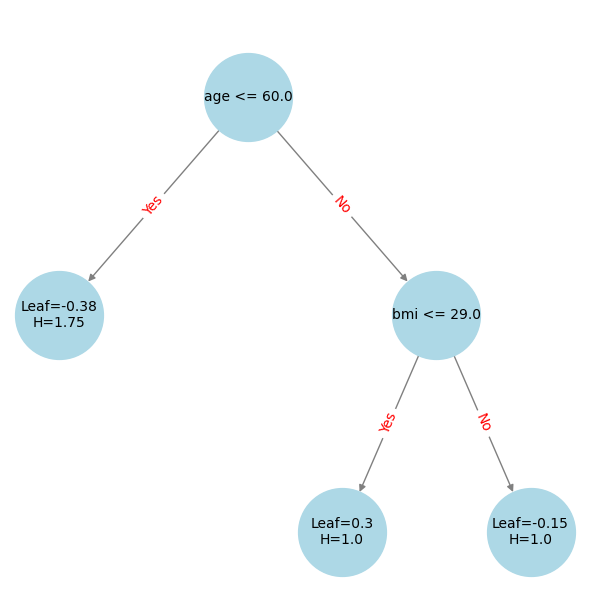

In [22]:
# df = model.get_booster()[0].trees_to_dataframe()
#
# print(df)


data = {
    'Tree': [0, 0, 0, 0, 0],
    'Node': [0, 1, 2, 3, 4],
    'ID': ['0-0', '0-1', '0-2', '0-3', '0-4'],
    'Feature': ['age', 'Leaf', 'bmi', 'Leaf', 'Leaf'],
    'Split': [60.0, None, 29.0, None, None],
    'Yes': ['0-1', None, '0-3', None, None],
    'No': ['0-2', None, '0-4', None, None],
    'Missing': ['0-2', None, None, None, None],
    'Gain': [1.00, -0.38, 0.15, 0.3, -0.15],
    'Cover': [2.0, 1.75, 1.0, 1, 1],
    'Category': [None, None, None, None, None]
}

df = pd.DataFrame(data)
# print(df)


plot_tree(df)

In [23]:
# # read the image tree.pdf and crop it
# # DO NOT USE PIL because it does not support pdf
# from PyPDF2 import PdfReader, PdfWriter
#
# def crop_pdf(input_path, output_path, x0, y0, x1, y1):
#     """
#     Crop a PDF file based on the provided coordinates.
#
#     Args:
#         input_path (str): The input PDF file path.
#         output_path (str): The output PDF file path.
#         x0 (int): The x-coordinate of the lower-left corner.
#         y0 (int): The y-coordinate of the lower-left corner.
#         x1 (int): The x-coordinate of the upper-right corner.
#         y1 (int): The y-coordinate of the upper-right corner.
#     """
#     with open(input_path, 'rb') as f:
#         reader = PdfReader(f)
#         writer = PdfWriter()
#
#         page = reader.pages[0]
#         page.mediabox.lower_left = (x0, y0)
#         page.mediabox.upper_right = (x1, y1)
#         writer.add_page(page)
#
#         with open(output_path, 'wb') as out:
#             writer.write(out)
#
#
# crop_pdf('tree_example.pdf', 'tree_example.pdf', 10, 10, 420, 400)

In [24]:
# with open(os.path.join(data_path, 'config', 'config.json')) as f:
#     config = json.load(f)
#     fn= config['features']
# print(f"Feature names: {fn}")
#
# # categorical_features = [name for name in fn if name not in ['age', 'avg_glucose_level', 'bmi']]
# # categorical_values = {name: np.unique(x[:, fn.index(name)]) for name in categorical_features}
# # numerical_ranges = {name: (np.min(x[:, fn.index(name)]), np.max(x[:, fn.index(name)])) for name in fn if
# #                     name not in categorical_features}
# #
# # # reorder
# # for name in categorical_values.keys():
# #     categorical_values[name] = np.sort(categorical_values[name])
# #
# # print(f"Categorical features: {categorical_features}")
# # print(f"Categorical values: {categorical_values}")

In [25]:
# from xgboost_reconstruction import XGBoostInfo, DatabaseReconstructor
#
# xgb_info = XGBoostInfo(model=model)
#
# tree_dfs = [df]
# reconstructor = DatabaseReconstructor(tree_dfs, fn, xgb_info)
#
# db = reconstructor.database.to_dataframe()
#
# # Definisci il subset di colonne da combinare
# colonne_da_unire = ['pi', 'gi', 'hi']
#
# # Creazione della nuova colonna con i valori concatenati
# db['Per-sample Statistics'] = db[colonne_da_unire].apply(
#     lambda row: ', '.join([f"{col} = {np.round(row[col], 2)}" for col in colonne_da_unire]), axis=1)
#
# db.drop(columns=colonne_da_unire, inplace=True)
# db.drop(columns='sigmoid', inplace=True)
#
# # reorder columns
# db = db[['age', 'bmi', 'Per-sample Statistics', 'label']]
#
# db

In [26]:
# # save db as a png
#
# import matplotlib.pyplot as plt
#
# # round the values to 2 decimal places
# db = db.round(2)
#
# fig, ax = render_mpl_table(db, header_columns=0, col_width=2)
# fig.tight_layout()
# fig.savefig('initialized_database.pdf', dpi=300)

Classes: [0. 1. 2. 1. 2. 0. 0. 2. 1. 0. 1. 2. 1. 0. 2. 1. 0. 2. 1. 2. 0. 1. 2. 0.
 1. 0. 2. 2. 0. 1. 1. 2. 0. 0. 2. 1. 1. 2. 0. 0. 1. 2. 0. 1. 2. 1. 0. 2.
 0. 1. 2. 1. 2. 0. 1. 2. 0. 2. 1. 0. 0. 2. 1. 2. 0. 1. 1. 2. 0. 0. 1. 2.
 1. 0. 2. 1. 2. 0. 1. 0. 2. 0. 2. 1. 2. 0. 1. 0. 1. 2.]


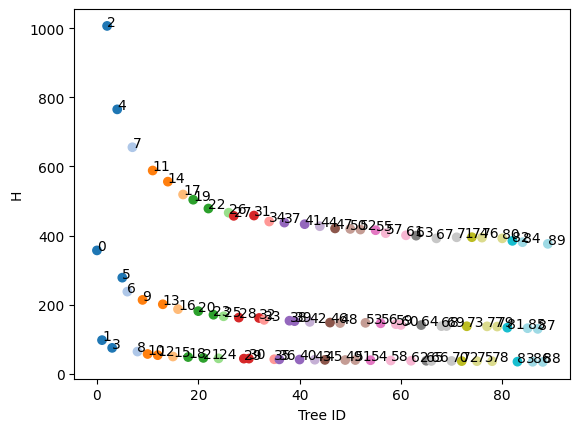

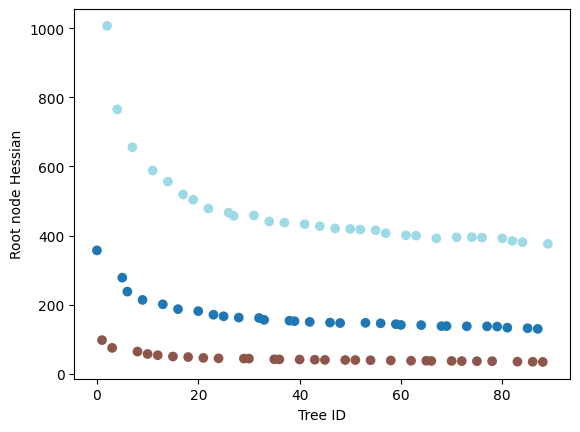

In [27]:
import re
import pickle

def _get_root_cover(model: xgb.Booster):
    """
    Get the cover of the root node for each tree.
    """
    num_trees = len(model.get_dump())
    data = []

    for tid in range(num_trees):
        dump = model.get_dump(with_stats=True)[tid]
        regex = re.compile(r'cover=(\d+\.\d+)')
        cover = regex.search(dump).group(1)
        regex_leaf = re.compile(r'leaf')
        num_leaf = len(regex_leaf.findall(dump))
        data.append((tid, float(cover), num_leaf))

    return data

def _get_classes(log_path: str, model: xgb.Booster, nRounds):
    """
    Cluster the trees into classes (clients) based on the cover of the root node.
    """
    data = _get_root_cover(model)
    classes = []
    num_trees = len(model.get_dump())
    nClients = 3

    tree_id = [i for i in range(num_trees)]
    data = [d[1] for d in data]

    data = np.column_stack((tree_id, data))

    from matplotlib import pyplot as plt

    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 0] // nClients, cmap='tab20')
    for i, txt in enumerate(data[:, 0]):
        plt.annotate(int(txt), (data[i, 0], data[i, 1]))
    plt.xlabel('Tree ID')
    plt.ylabel('H')

    plt.savefig(os.path.join(log_path, 'cover.pdf'))

    for r in range(nRounds):
        if r == 0:
            classes.append(np.vstack((data[:nClients, 0], data[:nClients, 1], [i for i in range(
                nClients)])).T)
        else:
            round_data = data[r * nClients:(r + 1) * nClients]
            round_covers = round_data[:, 1]
            prev_classes = classes[r - 1]
            prev_covers = prev_classes[:, 1]

            from scipy.optimize import linear_sum_assignment

            cost_matrix = np.abs(np.subtract.outer(round_covers, prev_covers))
            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            new_classes = []
            for i, j in zip(row_ind, col_ind):
                new_classes.append([round_data[i, 0], round_data[i, 1], prev_classes[j, 2]])
            classes.append(np.array(new_classes))

    classes = [c[:, 2] for c in classes]
    classes = np.concatenate(classes)
    print(f"Classes: {classes}")

    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=classes, cmap='tab20')
    # for i, txt in enumerate(data[:, 0]):
    #     plt.annotate(int(txt), (data[i, 0], data[i, 1]))
    plt.xlabel('Tree ID')
    plt.ylabel('Root node Hessian')

    plt.savefig(os.path.join(log_path, 'example_clustering.pdf'))
    return classes

with open("model.pkl", 'rb') as f:
    global_model = pickle.load(f)

model = xgb.Booster(model_file=global_model)

log_path = './'

nRounds = 30
classes = _get_classes(log_path, model, nRounds)